# Transfer learning and fine-tuning
- https://www.tensorflow.org/guide/keras/transfer_learning


In [10]:
# 주피터노트북 화면 넓게 보기 위한 용도
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Layers & models - weight 옵션
- weights: 전체
- trainable_weights: 학습과정에서 업데이트 가능한 weight
- non_trainable_weights: 학습되지 않고 전달만 되는 weight

In [3]:
# case 1
layer = keras.layers.Dense(3) # shape 몰라서 weight 생성 안 됨
layer.build((None, 4)) # shape initiate

print(len(layer.weights), len(layer.trainable_weights), len(layer.non_trainable_weights))

2 2 0


In [5]:
# case 2
layer = keras.layers.BatchNormalization()
layer.build((None, 4))

print(len(layer.weights), len(layer.trainable_weights), len(layer.non_trainable_weights))

4 2 2


In [6]:
# case 3
layer = keras.layers.Dense(3) # shape 몰라서 weight 생성 안 됨
layer.build((None, 4)) # shape initiate
layer.trainable = False

print(len(layer.weights), len(layer.trainable_weights), len(layer.non_trainable_weights))

2 0 2


In [7]:
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

layer1.trainable = False

In [8]:
initial_layer1_weights_values = layer1.get_weights()
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 228ms/step - loss: 0.0933


In [9]:
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(final_layer1_weights_values[0], final_layer1_weights_values[0])
np.testing.assert_allclose(final_layer1_weights_values[1], final_layer1_weights_values[1])

In [14]:
### Recursive setting of the trainable attribute
inner_model = keras.Sequential([
    keras.Input(shape=(3,)), 
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(3, activation='relu')
])

model = keras.Sequential([
    keras.Input(shape=(3,)), 
    inner_model,
    keras.layers.Dense(3, activation='sigmoid')
])

model.trainable = False
print(inner_model.trainable)
print(inner_model.layers[0].trainable)
# assert inner_model.layers[0].trainable == False ## test 용도

False
False


Transfer learning workflow
1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

In [16]:
base_model = keras.applications.Xception(
    weights='imagenet', input_shape=(150, 150, 3), include_top=False
)

In [17]:
base_model.trainable = False

In [20]:
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [21]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [23]:
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

- 전체를 retrain하는건 너무 오래 걸리고
- 마지막 단계만 train하면 overfitting 가능성

In [ ]:
base_model.trainable = True
# compile(): 모델 구조 혹은 특성을 freeze한다는 의미 
# trainable 값 변경 시, compile 새로 해줘야 함 (inner layer의 trainable이 바뀐 경우도 포함)

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

특수 케이스: BatchNormalization (이미지 모델에 자주 쓰이는 layer)
- mean, variance 2개의 weight를 가짐 (inference mode: not updated)
- fine-tuning할 때에는 현 데이터에 맞게 weight를 업데이트해줘야 함
- 따라서 해당 layer만 trainable로 변경 -> inference할 때에는 training=False로..???

### a custom training loop

In [24]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [25]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

In [27]:
# Iterate over the batches of a dataset.
for inputs, targets in new_dataset...:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))


### An end-to-end example: fine-tuning an image classification model on a cats vs. dogs

자체 이미지 데이터 사용할 때에는 tf.keras.preprocessing.image_dataset_from_directory 이용
- labeled dataset objects from a set of images on disk filed into class-specific folders
- transfer learning은 작은 데이터 사용 시 유리 (** 2.5만개 데이터는 작은 편이라고 판단)

In [29]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs", 
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

Dataset cats_vs_dogs downloaded and prepared to /Users/wonji/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [31]:
print(tf.data.experimental.cardinality(train_ds))

tf.Tensor(9305, shape=(), dtype=int64)


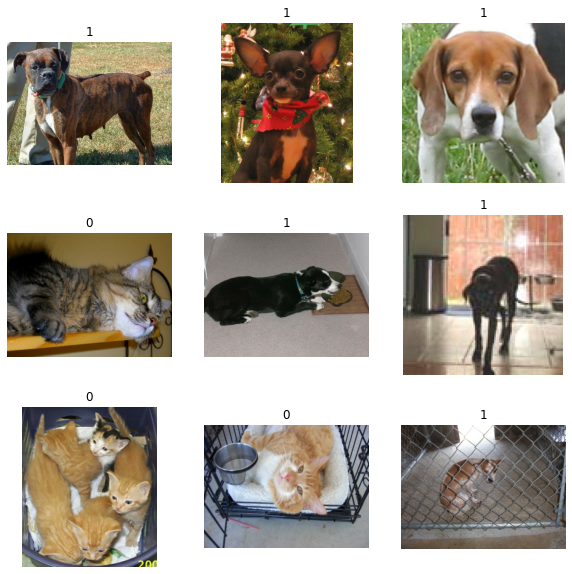

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(int(label))
    plt.axis('off')

In [33]:
img

<tf.Tensor: shape=(377, 500, 3), dtype=uint8, numpy=
array([[[ 81,  78,  71],
        [ 65,  62,  55],
        [ 49,  46,  39],
        ...,
        [ 93,  97, 145],
        [ 98, 102, 150],
        [ 97, 101, 149]],

       [[ 77,  74,  67],
        [ 56,  53,  46],
        [ 39,  36,  29],
        ...,
        [154, 158, 205],
        [152, 156, 203],
        [193, 197, 244]],

       [[ 70,  65,  59],
        [ 46,  41,  35],
        [ 32,  27,  21],
        ...,
        [174, 179, 221],
        [185, 188, 231],
        [205, 208, 249]],

       ...,

       [[ 75,  62,  54],
        [ 73,  60,  52],
        [ 71,  58,  50],
        ...,
        [ 94,  86,  84],
        [ 91,  83,  80],
        [ 89,  81,  78]],

       [[ 77,  64,  56],
        [ 73,  60,  52],
        [ 69,  56,  48],
        ...,
        [109, 101,  99],
        [107,  99,  96],
        [106,  98,  95]],

       [[ 74,  59,  52],
        [ 72,  57,  50],
        [ 73,  58,  51],
        ...,
        [101,  93,  9

데이터 표준화 
- a fixed image size로 맞추기 (150x150)
- pixel values between -1 and 1 by Normalization layer

In [36]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [37]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

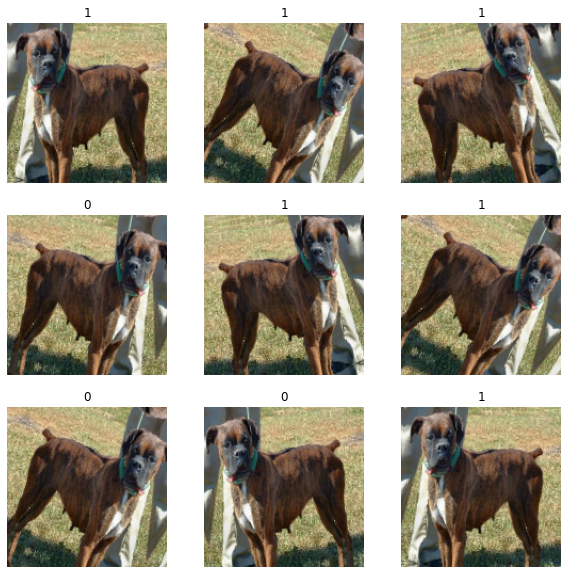

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

import numpy as np 

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype('int32'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [41]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])

In [42]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2049

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 214s 729ms/step - loss: 0.2647 - binary_accuracy: 0.8622 - val_loss: 0.0791 - val_binary_accuracy: 0.9708
Epoch 2/20
291/291 [==============================] - 216s 742ms/step - loss: 0.1315 - binary_accuracy: 0.9397 - val_loss: 0.0750 - val_binary_accuracy: 0.9690
Epoch 3/20
291/291 [==============================] - 215s 740ms/step - loss: 0.1108 - binary_accuracy: 0.9529 - val_loss: 0.0719 - val_binary_accuracy: 0.9712
Epoch 4/20
291/291 [==============================] - 222s 763ms/step - loss: 0.1094 - binary_accuracy: 0.9524 - val_loss: 0.0713 - val_binary_accuracy: 0.9721
Epoch 5/20
291/291 [==============================] - 213s 733ms/step - loss: 0.1013 - binary_accuracy: 0.9585 - val_loss: 0.0716 - val_binary_accuracy: 0.9716
Epoch 6/20
291/291 [==============================] - 213s 732ms/step - loss: 0.1083 - binary_accuracy: 0.9530 - val_loss: 0.0701 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [====================

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds) # validation data